In [1]:
import torch  # 导入PyTorch库
from torch import nn  # 从PyTorch中导入神经网络模块
from d2l import torch as d2l  # 从d2l库中导入PyTorch相关功能，并别名为d2l
#                              全局均值和方差          eps：为了避免除0      momentum：更新 movingmean moving var    
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 定义batch_norm函数，批量归一化。此函数接受输入X（数据输入），gamma（缩放参数），
    # beta（偏移参数），moving_mean（移动平均的均值），moving_var（移动平均的方差），
    # eps（epsilon，避免分母为0的小常数），momentum（动量，用于移动平均的更新）。

    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    # torch.is_grad_enabled()：判断是否启用了自动梯度计算（训练模式）
    if not torch.is_grad_enabled():# 如果不要算梯度
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        #           整个数据集上的全局mean      全局var                      在做inference的时候没有批量的概念
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)  # 归一化输入X
    else:
        #  要么是2 全连接 要么是4 卷积层            
        assert len(X.shape) in (2, 4)  # 确保输入X的维度是2（全连 接层）或4（卷积层）

        if len(X.shape) == 2:
            # 全连接层：2个维度，batch_size    features

            # 如果是全连接层，计算特征维上的均值和方差
            #           对每一个特征列求均值
            mean = X.mean(dim=0)  # 计算每个特征（列）的均值，dim=0表示按列计算
            var = ((X - mean) ** 2).mean(dim=0)  # 计算每个特征的方差
        else:
            # 卷积层：4个维度，batch_size  channels height  width
            # 如果是卷积层，计算通道维（axis=1）上的均值和方差
            # X.mean(dim=(0, 2, 3), keepdim=True)：在维度0、2、3（批次、宽度、高度）上求均值，保持形状不变
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # 计算通道维的均值
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)  # 计算通道维的方差

        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)  # 标准化输入X
        # 更新移动平均的均值和方差
        # momentum（动量）用于平滑移动均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean  # 更新移动均值
        moving_var = momentum * moving_var + (1.0 - momentum) * var  # 更新移动方差

    # gamma * X_hat + beta：对标准化后的结果进行缩放（gamma）和移位（beta）
    Y = gamma * X_hat + beta  # 缩放和偏移
    return Y, moving_mean.data, moving_var.data  # 返回归一化结果Y，更新后的移动均值和方差


In [2]:
class BatchNorm(nn.Module):  # 定义BatchNorm类，继承自nn.Module类，批量归一化模块
    # num_features：完全连接层的输出数量或卷积层的输出通道数
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):  # 初始化方法，接收参数num_features（特征数量）和num_dims（维度）
        super().__init__()  # 调用父类的初始化方法
        if num_dims == 2:  # 判断是否是全连接层（num_dims == 2）
            shape = (1, num_features)  # 如果是全连接层，shape设为(1, num_features)
        else:  # 否则，认为是卷积层
            shape = (1, num_features, 1, 1)  # 如果是卷积层，shape设为(1, num_features, 1, 1)
        # 定义参与求梯度和迭代的拉伸（gamma）和偏移（beta）参数，分别初始化为1和0
        # gamma：需要拟合的方差  beta：需要拟合的均值 gamma beta需要被迭代
        self.gamma = nn.Parameter(torch.ones(shape))  # gamma参数，初始化为1（用于缩放）
        self.beta = nn.Parameter(torch.zeros(shape))  # beta参数，初始化为0（用于偏移）
        # 非模型参数的变量，移动均值（moving_mean）初始化为0，移动方差（moving_var）初始化为1
        self.moving_mean = torch.zeros(shape)  # 初始化移动均值为0
        self.moving_var = torch.ones(shape)  # 初始化移动方差为1

    def forward(self, X):  # 定义前向传播方法
        # 如果X所在的设备与moving_mean不同，将moving_mean和moving_var复制到X所在的设备上
        if self.moving_mean.device != X.device:  # 检查移动均值是否在与输入X相同的设备上
            self.moving_mean = self.moving_mean.to(X.device)  # 将moving_mean复制到X所在的设备上
            self.moving_var = self.moving_var.to(X.device)  # 将moving_var复制到X所在的设备上
        # 调用batch_norm函数，更新移动均值和方差，并计算归一化输出Y
        Y, self.moving_mean, self.moving_var = batch_norm(  # 调用batch_norm函数进行批量归一化
            X, self.gamma, self.beta, self.moving_mean,  # 传入输入X，gamma，beta，移动均值和移动方差
            self.moving_var, eps=1e-5, momentum=0.9)  # 传入eps（防止除零的微小常数）和动量momentum
        return Y  # 返回归一化后的输出Y


In [3]:
net = nn.Sequential(# batchnorm在卷积层后在激活层前
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))# 输出层不做

KeyboardInterrupt: 

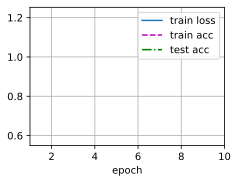

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [5]:
net[1].gamma.reshape((-1,)) 
# 第一层的gamma拿出来看
# 将网络中第1层（BatchNorm层）的gamma参数进行形状调整为一维向量
# net[1]：指的是网络中的第1层，即BatchNorm批量归一化层
# gamma：缩放参数，用于对数据进行标准化后的缩放
# reshape((-1,))：将gamma参数的形状重构为一维（-1表示自动推断维度）

net[1].beta.reshape((-1,))  # 将网络中第1层（BatchNorm层）的beta参数进行形状调整为一维向量
# net[1]：指的是网络中的第1层，即BatchNorm批量归一化层
# beta：偏移参数，用于对数据进行标准化后的偏移
# reshape((-1,))：将beta参数的形状重构为一维（-1表示自动推断维度）


tensor([ 0.7716,  0.2099, -0.5708, -0.0919,  0.2246,  0.7738],
       grad_fn=<ReshapeAliasBackward0>)

In [6]:
"""简明实现"""

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))



KeyboardInterrupt: 

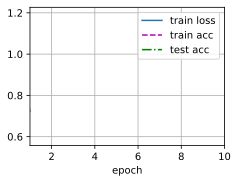

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())